In [1]:
import torch
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
import utils
import resnet
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import DataAugmentations as Aug
import torch.nn as nn


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = '/Users/mouzam/TSAI/data/cifar-10-batches-py/batches.meta' 
metadata = unpickle(metadata_path)

#Decodong from byte literal to regular string : b'dog' --> 'dog'
inttoclasses = {i:classes.decode('utf-8') for  i,classes in  enumerate(metadata[b'label_names'])}

In [3]:
inttoclasses

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [3]:
#Mean Train
print(Aug.train_data.data.mean(axis=(0, 1, 2))/255)
#Mean Test
print(Aug.test_data.data.mean(axis=(0, 1, 2))/255)

[0.49139968 0.48215841 0.44653091]
[0.49421428 0.48513139 0.45040909]


In [4]:
#Std Train
print(Aug.train_data.data.std(axis=(0, 1, 2))/255)
#Std test
print(Aug.test_data.data.std(axis=(0, 1, 2))/255)

[0.24703223 0.24348513 0.26158784]
[0.24665252 0.24289226 0.26159238]


In [33]:
training_iterator = iter(Aug.train_loader)

In [38]:
batch_images, batch_labels = next(training_iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

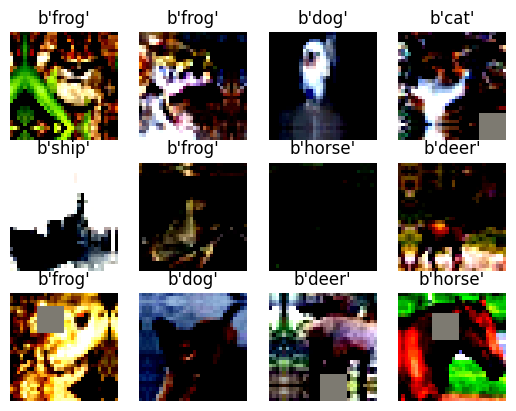

In [39]:

# Print 12 images to see the sample data
for i in range(12):
    plt.subplot(3,4,i+1)
    im = batch_images[i]
    im = np.transpose(im, axes=[1, 2, 0])
    plt.imshow(im)
    plt.title(inttoclasses[batch_labels[i].item()])
    plt.axis('off')

In [4]:

has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

In [5]:
def get_lr(optimizer):
    """"
    for tracking how your learning rate is changing throughout training
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [6]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

def train(model, device, train_loader, optimizer, scheduler,criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
 
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    #print('Printing batch id -->' + str(batch_idx))
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #pdb.set_trace()
    #loss = F.nll_loss(y_pred, target)
    loss = criterion(y_pred, target)
    train_losses.append(loss)
    lrs.append(get_lr(optimizer))
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    scheduler.step()
    # Update pbar-tqdm
    #pdb.set_trace()
    _, pred = torch.max(y_pred.data, 1)
    #pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #print(lr)
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += criterion(output, target).item()
            _, pred = torch.max(output.data, 1)
            #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # test_acc.append(100. * correct / len(test_loader.dataset))

    return test_loss


In [7]:
device

'mps'

In [8]:
model = resnet.ResNet18().to(device= device)

# model = model.CustomResNet().to(device)

/Users/mouzam/TSAI/.venv/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
 66%|██████▋   | 133/200 [01:52<00:56,  1.18it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 4.65E-02


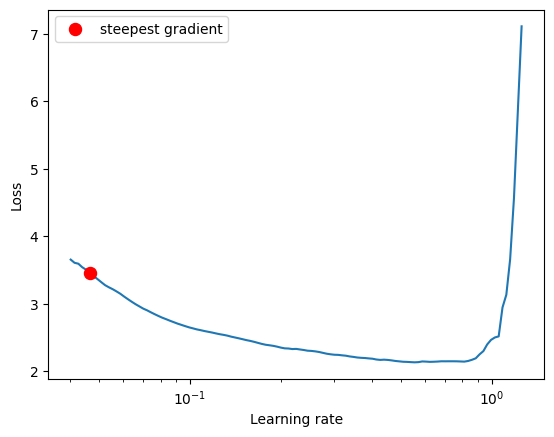

In [9]:
from torch_lr_finder import LRFinder

# #model = CustomResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.03, weight_decay= 1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(Aug.train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:

#optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
#step_sizes = 8  # Adjust the learning rate after 10, 20, and 30 epochs
gamma = 0.1  # The factor by which the learning rate will be reduced

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_sizes, gamma=gamma, verbose=True)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
num_epochs = 20

#max_lr=4.38E-02
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=4.65E-02, steps_per_epoch=len(Aug.train_loader), epochs=num_epochs,
                                                pct_start= 5/num_epochs, 
                                                div_factor = 100, 
                                                three_phase= False,
                                                final_div_factor=100,
                                                anneal_strategy = 'linear',
                                                verbose= False)
# New Line

#criterion = nn.CrossEntropyLoss()

#criterion_test = nn.CrossEntropyLoss(reduction='sum')

   
for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, Aug.train_loader, optimizer, scheduler,criterion)
    test_loss = test(model, device, Aug.test_loader,criterion)
    #scheduler.step(test_loss)


Epoch 1


Loss=1.313173770904541 Batch_id=97 Accuracy=42.38: 100%|██████████| 98/98 [01:27<00:00,  1.13it/s] 



Test set: Average loss: 0.0036, Accuracy: 4068/10000 (40.68%)

Epoch 2


Loss=0.996616542339325 Batch_id=97 Accuracy=55.16: 100%|██████████| 98/98 [01:24<00:00,  1.15it/s] 



Test set: Average loss: 0.0023, Accuracy: 5923/10000 (59.23%)

Epoch 3


Loss=1.1366854906082153 Batch_id=97 Accuracy=62.38: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s]



Test set: Average loss: 0.0025, Accuracy: 5625/10000 (56.25%)

Epoch 4


Loss=0.9744628071784973 Batch_id=97 Accuracy=64.75: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]



Test set: Average loss: 0.0034, Accuracy: 5110/10000 (51.10%)

Epoch 5


Loss=1.0901734828948975 Batch_id=97 Accuracy=65.52: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]



Test set: Average loss: 0.0046, Accuracy: 4785/10000 (47.85%)

Epoch 6


Loss=0.8903716206550598 Batch_id=97 Accuracy=66.86: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]



Test set: Average loss: 0.0021, Accuracy: 6385/10000 (63.85%)

Epoch 7


Loss=0.8634077906608582 Batch_id=97 Accuracy=69.75: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]



Test set: Average loss: 0.0029, Accuracy: 5219/10000 (52.19%)

Epoch 8


Loss=0.8198859691619873 Batch_id=97 Accuracy=71.25: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s]



Test set: Average loss: 0.0031, Accuracy: 5144/10000 (51.44%)

Epoch 9


Loss=0.785786509513855 Batch_id=97 Accuracy=72.45: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s] 



Test set: Average loss: 0.0031, Accuracy: 5624/10000 (56.24%)

Epoch 10


Loss=0.7530658841133118 Batch_id=97 Accuracy=74.08: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]



Test set: Average loss: 0.0019, Accuracy: 6782/10000 (67.82%)

Epoch 11


Loss=0.6819126605987549 Batch_id=97 Accuracy=74.82: 100%|██████████| 98/98 [01:24<00:00,  1.15it/s]



Test set: Average loss: 0.0023, Accuracy: 6477/10000 (64.77%)

Epoch 12


Loss=0.6444952487945557 Batch_id=97 Accuracy=76.04: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s]



Test set: Average loss: 0.0022, Accuracy: 6556/10000 (65.56%)

Epoch 13


Loss=0.7194030284881592 Batch_id=97 Accuracy=77.31: 100%|██████████| 98/98 [01:24<00:00,  1.15it/s]



Test set: Average loss: 0.0016, Accuracy: 7185/10000 (71.85%)

Epoch 14


Loss=0.6168165802955627 Batch_id=97 Accuracy=78.51: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s] 



Test set: Average loss: 0.0014, Accuracy: 7714/10000 (77.14%)

Epoch 15


Loss=0.5442844033241272 Batch_id=97 Accuracy=79.60: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s]



Test set: Average loss: 0.0018, Accuracy: 7192/10000 (71.92%)

Epoch 16


Loss=0.48867884278297424 Batch_id=97 Accuracy=81.04: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]



Test set: Average loss: 0.0014, Accuracy: 7592/10000 (75.92%)

Epoch 17


Loss=0.5162922143936157 Batch_id=97 Accuracy=82.35: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s] 



Test set: Average loss: 0.0012, Accuracy: 8023/10000 (80.23%)

Epoch 18


Loss=0.3766072988510132 Batch_id=97 Accuracy=84.05: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s] 



Test set: Average loss: 0.0010, Accuracy: 8355/10000 (83.55%)

Epoch 19


Loss=0.3399249017238617 Batch_id=97 Accuracy=86.24: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s] 



Test set: Average loss: 0.0009, Accuracy: 8558/10000 (85.58%)

Epoch 20


Loss=0.3972846567630768 Batch_id=97 Accuracy=88.26: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s] 



Test set: Average loss: 0.0007, Accuracy: 8884/10000 (88.84%)



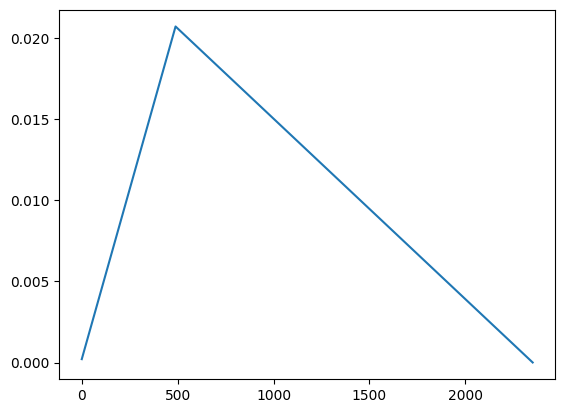

In [9]:
len(lrs)
plt.plot(lrs)

In [10]:
images, p_labels, a_labels = utils.misclassified_images(model,Aug.test_loader, 20 , device, criterion)

/Users/mouzam/TSAI/TSAI-S11/utils.py:30: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  incorrect_preds = data[~correct_preds]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


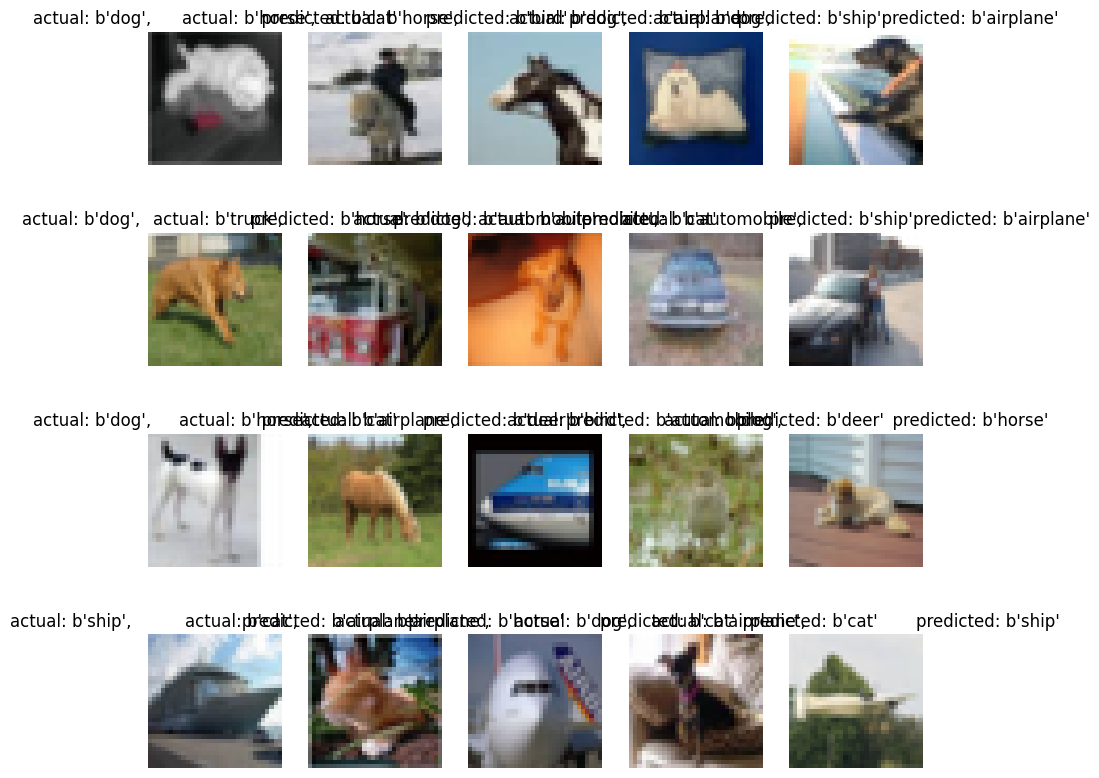

In [11]:
utils.show_misclassfied_images(images,inttoclasses,a_labels,p_labels)

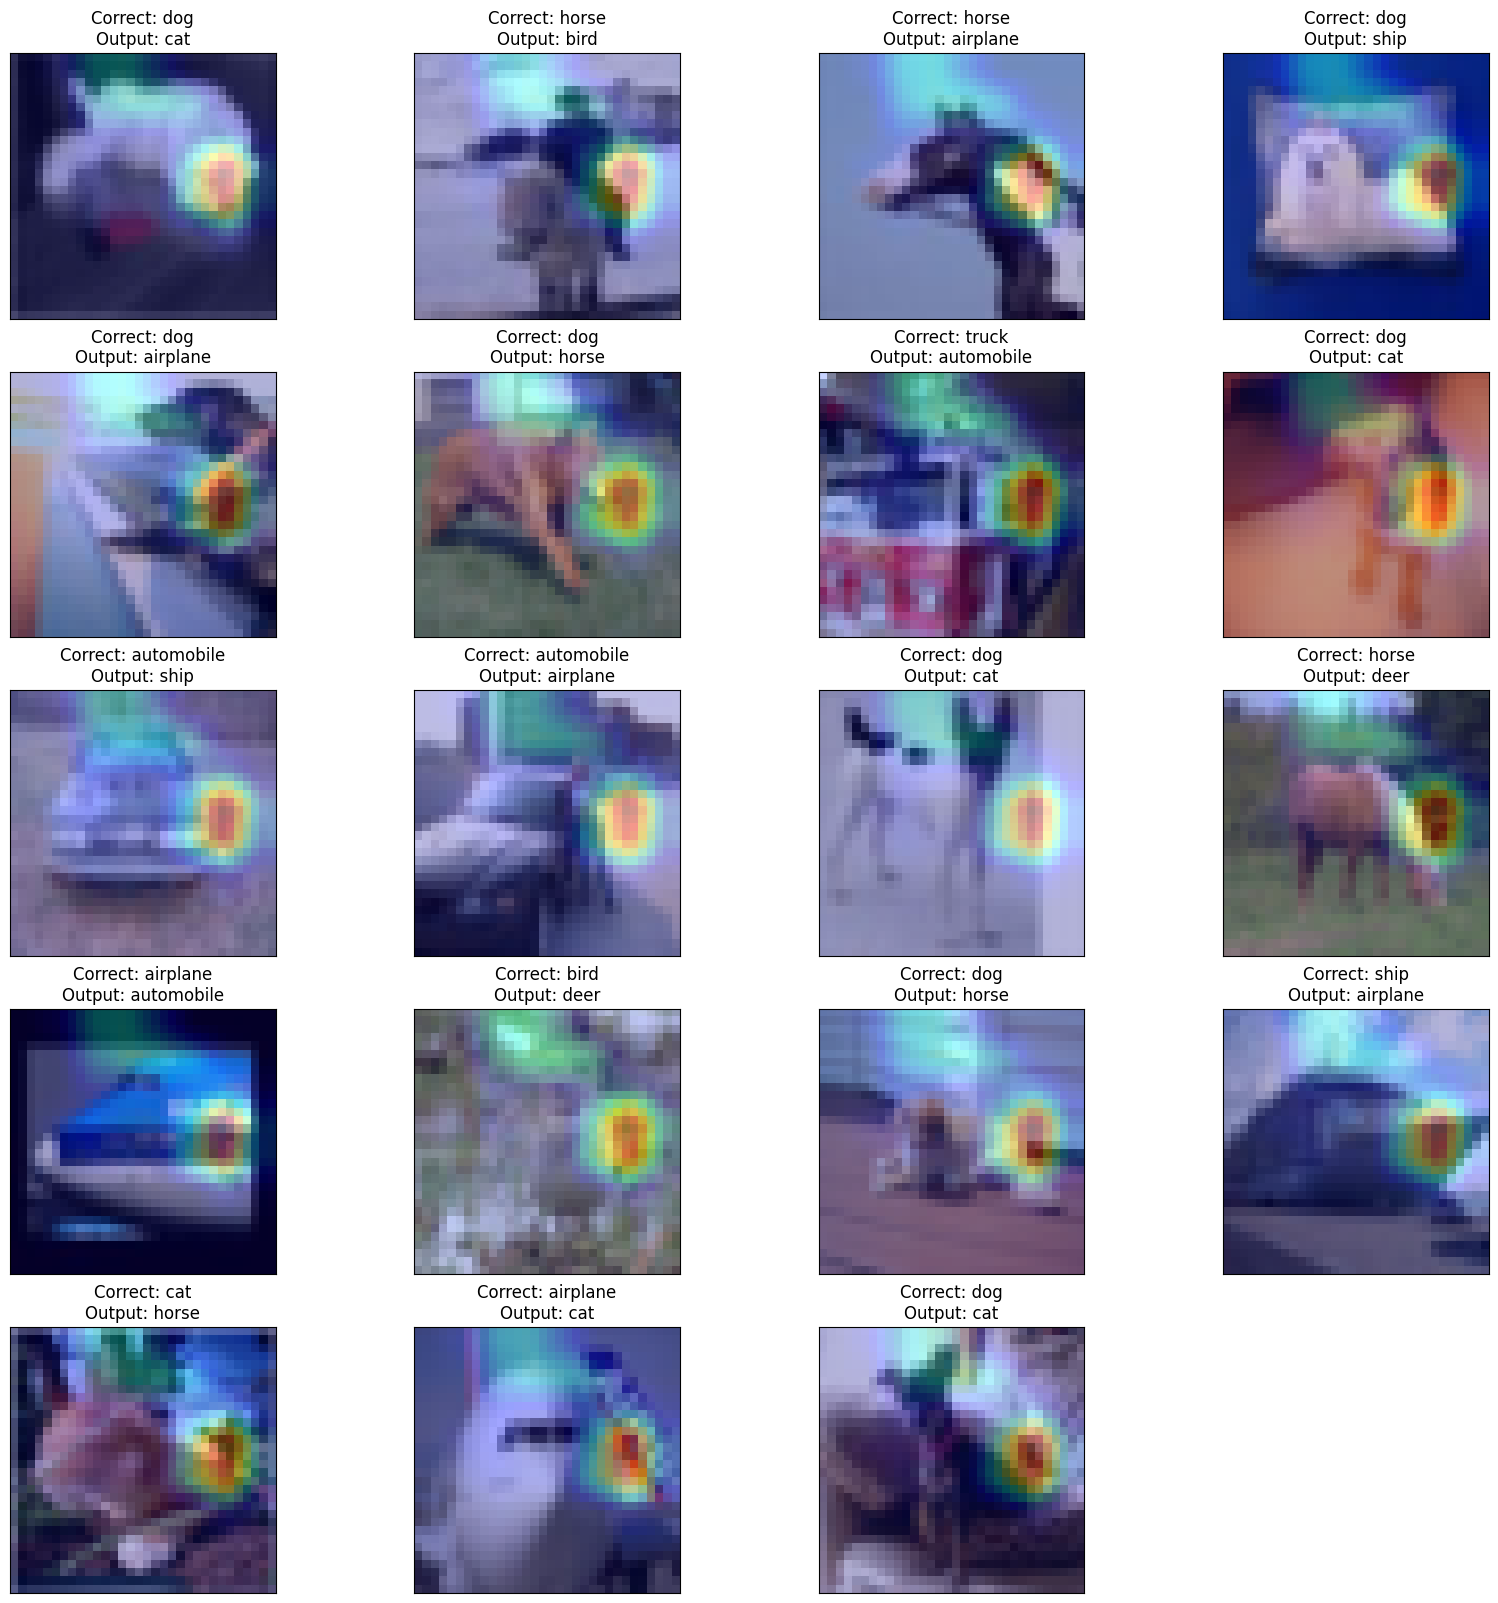

In [48]:
target_layers = [model.layer3[-1]]
utils.show_grad_cam_images(model, target_layers, images, inttoclasses,a_labels,p_labels)


In [17]:
model = resnet.ResNet18()
summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,